# Comparing SMEs

In [1]:
from __future__ import print_function, division, absolute_import
import sys, os
import socket
import time
import numpy as np
# import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from set_batch_parameters import *      # Define parameter combinations here
from cssegmod import basemod as model   # Model class
from scipy.interpolate import UnivariateSpline

Purpose:

* This notebook uses data saved from running ``COMPARESTEADYSTATES_MONTY_FUTURE.PY``

    * Compare SME outcomes across different inflation rates $\tau$

    * Each SME outcome is computed by simulation over a single agent for a very long horizon

    * Computed SME money distribution is end-of-period distribution


* See ``COMPARESTEADYSTATES_MONTY_FUTURE.PY`` for more results that also uses a panel of agents

In [2]:
klmod = model(m_gridsize_ltk = 24, m_gridsize_gtk = 48)

# Preliminaries and functions

Set the path for batch experimental results from running ``COMPARESTEADYSTATES_MONTY_FUTURE.PY``:

In [3]:
# Path to saved experiments
path='comparemonty2future/benchmark/out/'
# path='comparemonty2future/benchmarkzerofixcost/out/'

For the welfare (Consumption Equivalent Variation or CEV) calculation below we use the zero-inflation SME as the baseline for comparison. 

So all the CEV numbers reported will be read as **how much consumption is lost by** or **must be given to** an **average agent** (i.e., negative CEV number) to move her from the zero-inflation economy to another $\tau$-inflation SME in question}.

In [4]:
def CEV(V_old, V_new, Display=True):
    """Variation in CM consumption (relative to initial SME)
    that is equivalent to change in mean ex-ante
    welfare across heterogeneous agents"""
    # Absolute welfare change
    d = V_new - V_old
    # # Percentage CEV - Handcoded version (MAIN.PY)
    # Z_old = iU(V_old)
    # Z_new = iU(V_new)
    # Δ_hand = 400*(Z_old/Z_new - 1.0)
    # Percentage CEV - Auto class version
    klmod.C_min = 1e-12
    Δ_auto = 400*(klmod.invU_CM(V_new)/klmod.invU_CM(V_old)-1.0)
    if Display==True:
        print("Ex-ante Mean Welfare change is %6.2f" %(d))
        # print("CEV (hand) is %6.8f percent p.a." %(Δ_hand))
        print("CEV (auto) is %6.8f percent p.a." %(Δ_auto))
    return Δ_auto, d

The zero-inflation SME average, ex-ante welfare:

In [5]:
# Calculate baseline economy's welfare: V_old at τ=0
results_zero = np.load(path+'experiment1/results.npy',
                    encoding='latin1', allow_pickle=True).item()
# Fitted ex-ante value function
Vbarfit_zero = results_zero['valuefit']['Vbar']
m_sim_zero = results_zero['distro']['simhistory']['m']
Vbarsim_zero = Vbarfit_zero(m_sim_zero)
# Mean valuation
V_zero = Vbarsim_zero.mean()

Storage as ``dict``ionaries for plotting later:

In [6]:
N_experiments = 23

y_stats = {   'm' : {
                  'mean'     : [],
                  'sd'       : [],
                  'skew'     : [],
                  'kurtosis' : [],
                  '10 percentile' : [],
                  '50 percentile' : [],
                  '90 percentile' : [],
                  '50/10 percentile': [],
                  '90/10 percentile': [],
                  '90/50 percentile': [],
                  },
              'cons_all' : {
                  'mean'     : [],
                  'sd'       : [],
                  'skew'     : [],
                  'kurtosis' : [],
                  '10 percentile' : [],
                  '50 percentile' : [],
                  '90 percentile' : [],
                  '50/10 percentile': [],
                  '90/10 percentile': [],
                  '90/50 percentile': [],
                  },
              'x' : {
                  'mean'     : [],
                  'sd'       : [],
                  'skew'     : [],
                  'kurtosis' : [],
                  '10 percentile' : [],
                  '50 percentile' : [],
                  '90 percentile' : [],
                  '50/10 percentile': [],
                  '90/10 percentile': [],
                  '90/50 percentile': [],
                  },
              'xprime' : {
                  'mean'     : [],
                  'sd'       : [],
                  'skew'     : [],
                  'kurtosis' : [],
                  '10 percentile' : [],
                  '50 percentile' : [],
                  '90 percentile' : [],
                  '50/10 percentile': [],
                  '90/10 percentile': [],
                  '90/50 percentile': [],
                  },
              'b' : {
                  'mean'     : [],
                  'sd'       : [],
                  'skew'     : [],
                  'kurtosis' : [],
                  '10 percentile' : [],
                  '50 percentile' : [],
                  '90 percentile' : [],
                  '50/10 percentile': [],
                  '90/10 percentile': [],
                  '90/50 percentile': [],
                  },
              'q' : {
                  'mean'     : [],
                  'sd'       : [],
                  'skew'     : [],
                  'kurtosis' : [],
                  '10 percentile' : [],
                  '50 percentile' : [],
                  '90 percentile' : [],
                  '50/10 percentile': [],
                  '90/10 percentile': [],
                  '90/50 percentile': [],
                  },        
              'p' : {
                  'mean'     : [],
                  'sd'       : [],
                  'skew'     : [],
                  'kurtosis' : [],
                  '10 percentile' : [],
                  '50 percentile' : [],
                  '90 percentile' : [],
                  '50/10 percentile': [],
                  '90/10 percentile': [],
                  '90/50 percentile': [],
                  },
              'p_all' : {
                  'mean'     : [],
                  'sd'       : [],
                  'skew'     : [],
                  'kurtosis' : [],
                  '10 percentile' : [],
                  '50 percentile' : [],
                  '90 percentile' : [],
                  '50/10 percentile': [],
                  '90/10 percentile': [],
                  '90/50 percentile': [],
                  },
              'bx/m' : {
                  'mean'     : [],
                  'sd'       : [],
                  'skew'     : [],
                  'kurtosis' : [],
                  '10 percentile' : [],
                  '50 percentile' : [],
                  '90 percentile' : [],
                  '50/10 percentile': [],
                  '90/10 percentile': [],
                  '90/50 percentile': [],
                  },
               'cev' : {
                  'mean'     : [],
                  'sd'       : [],
                  'skew'     : [],
                  'kurtosis' : [],
                  '10 percentile' : [],
                  '50 percentile' : [],
                  '90 percentile' : [],
                  '50/10 percentile': [],
                  '90/10 percentile': [],
                  '90/50 percentile': [],
                  },
           }

Loop over each SME experiment, import its results and extract variables of interest for plots later:

In [7]:
CMPart = []
gini = []
cev = []
gini_q = []
gini_cons = []

# Loop to extract DM variables and construct moments of interest
for experiment in range(N_experiments):
    # Get results.npy file for experiment
    file=path+'experiment'+str(experiment)+'/results.npy'
    results = np.load(file, encoding='latin1', allow_pickle=True).item()

    # Fitted value functions
    value_functions = results['valuefit']
    Vbarfit = value_functions['Vbar']
    Vfit = value_functions['V']
    Bfit = value_functions['B']
    Wfit = value_functions['W']

    # policy functions evaluated on grid
    policy_functions = results['policygrid']
    lstar = policy_functions['lstar']
    lfit = klmod.InterpFun1d(klmod.m_grid, lstar)
    ystar = policy_functions['ystar']
    yfit = klmod.InterpFun1d(klmod.m_grid, ystar)
    bstar = policy_functions['bstar']
    bfit = klmod.InterpFun1d(klmod.m_grid, bstar)
    qstar = policy_functions['qstar']
    qfit = klmod.InterpFun1d(klmod.m_grid, qstar)
    xstar = policy_functions['xstar']
    xfit = klmod.InterpFun1d(klmod.m_grid, xstar)
    
    # Get simulated variables of interest
    simhistory = results['distro']['simhistory']
    participation = results['distro']['simhistory']['parti']

    msim = simhistory['m']
    xsim = simhistory['x'][participation==1]
    qsim = simhistory['q'][participation==1]
    bsim = simhistory['b'][participation==1]
    participation = simhistory['parti']
    partrateCM = float(participation[participation==2].size/participation.size)
    partrateDM = 1.0 - partrateCM
    CMPart.append(partrateCM)
    # # DM marginal propensity to consume
    # qprime = qfit.derivative()
    # m_DM_match = msim[participation==1]
    # mpcsim = np.absolute(qprime(m_DM_match)*(m_DM_match/qsim))
    bprime = bfit.derivative()
    qprime = qfit.derivative()
    xprime = xfit.derivative()

    # All consumption 
    consim = simhistory['q'].copy()
    consim[participation==2] = klmod.Cstar

    # Welfare distribution - current experiment
    Vbarsim = Vbarfit(msim)
    V = Vbarsim.mean()
    V_10 = np.percentile(Vbarsim, 10)
    V_50 = np.percentile(Vbarsim, 51)
    V_90 = np.percentile(Vbarsim, 90)
    
    # Welfare distribution - reference τ=0 economy
    V_zero = Vbarsim_zero.mean()
    V_zero_10 = np.percentile(Vbarsim_zero, 10)
    V_zero_50 = np.percentile(Vbarsim_zero, 51)
    V_zero_90 = np.percentile(Vbarsim_zero, 90)
    
    # CEV stats
    cev_mean = CEV(V_zero, V, Display=False)[0]
    cev_10 = CEV(V_zero_10, V_10, Display=False)[0]
    cev_50 = CEV(V_zero_50, V_50, Display=False)[0]
    cev_90 = CEV(V_zero_90, V_90, Display=False)[0]
    
    #     cevsim = CEV(V_zero, Vbarsim, Display=False)[0]
    #     V = Vbarsim.mean()
    cev.append(cev_mean)

    # Loop over variables in y_stats
    for i, key in enumerate(y_stats.keys()):
        if key == 'cons_all':
            data_sim = consim
        elif key == 'p':
            data_sim = xsim/qsim
        elif key == 'p_all':
            data_sim = np.empty(participation.shape)
            data_sim[participation==1] = xsim/qsim
            data_sim[participation==2] = 1.0
            data_sim = data_sim[participation != 0]
        elif key == 'bx/m':
            # data_sim = partrateDM*bsim*xsim/msim[participation==1]
            data_sim = bsim*xsim/msim[participation==1]
        # elif key == 'mpc':
        #     data_sim = mpcsim
        elif key == 'cev':
            data_sim = None
        elif key == 'm':
            data_sim = simhistory[key][participation==1]
        elif key == 'xprime':
            m = simhistory['m'][participation==1]
            m = m[m != 0.0]
            data_sim = xprime(m)
        else:
            data_sim = simhistory[key][participation==1]
        # Enter and append first four moments
        # data_sim = np.log(data_sim)
        if key == 'cev':
            y_stats[key]['mean'].append(cev_mean)
            y_stats[key]['sd'].append('na')
            y_stats[key]['skew'].append('na')
            y_stats[key]['kurtosis'].append('na')
            y_p10 = cev_10
            y_p50 = cev_50
            y_p90 = cev_90
        else:
            y_stats[key]['mean'].append(np.mean(data_sim))
            y_stats[key]['sd'].append(np.std(data_sim))
            y_stats[key]['skew'].append(skew(data_sim))
            y_stats[key]['kurtosis'].append(kurtosis(data_sim))
            y_p10 = np.percentile(data_sim, 10)
            y_p50 = np.percentile(data_sim, 51)
            y_p90 = np.percentile(data_sim, 90)
        y_stats[key]['10 percentile'].append(y_p10)
        y_stats[key]['50 percentile'].append(y_p50)
        y_stats[key]['90 percentile'].append(y_p90)
        y_stats[key]['50/10 percentile'].append(y_p50/y_p10)
        y_stats[key]['90/10 percentile'].append(y_p90/y_p10)
        y_stats[key]['90/50 percentile'].append(y_p90/y_p50)
    # Gini coefficient
    gini.append(klmod.gini_rawdata(msim))

    # Consumption - focus on DM q since CM C is always constant
    qsim = qfit(msim)
    gini_q.append(klmod.gini_rawdata(qsim))

    # Consumption all
    gini_cons.append(klmod.gini_rawdata(consim))

# Convert to numpy array
gini = np.asarray(gini)
cev = np.asarray(cev)
gini_q = np.asarray(gini_q)
gini_cons = np.asarray(gini_cons)

/tmp/ipykernel_26244/37481070.py:119: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  y_stats[key]['skew'].append(skew(data_sim))
/tmp/ipykernel_26244/37481070.py:120: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  y_stats[key]['kurtosis'].append(kurtosis(data_sim))
/tmp/ipykernel_26244/37481070.py:127: RuntimeWarning: invalid value encountered in scalar divide
  y_stats[key]['50/10 percentile'].append(y_p50/y_p10)
/tmp/ipykernel_26244/37481070.py:128: RuntimeWarning: invalid value encountered in scalar divide
  y_stats[key]['90/10 percentile'].append(y_p90/y_p10)
/tmp/ipykernel_26244/37481070.py:129: RuntimeWarning: invalid value encountered in scalar divide
  y_stats[key]['90/50 percentile'].append(y_p90/y_p50)


**IMPORTANT**: These parameters are from ``COMPARESTEADYSTATES_MONTY_FUTURE.PY``. 

Make sure they match, depending on the experimental setting used:

In [8]:
# ================= EXTERNALLY CALIBRATED PARAMETERS HERE ==============
beta_freq = 'Q'

# Inflation and interest rates from annual data
# Lucas and Nicolini, annual 3-mth T-bill-rate mean = 3.4% p/a
# FRED CPI inflation rate 3.9% p/a
# Sample: 1915 to 2007
tau_data_annual = 0.034329539689549854
i_data_annual = 0.03854204301075268
beta_annual  = (1. + tau_data_annual)/(1. + i_data_annual)
if beta_freq == 'Q':
    tau_data = (1.0 + 0.034)**0.25 - 1.0
    i_data = (1.0 + 0.039)**0.25 - 1.0
elif beta_freq == 'A':
    tau_data = tau_data_annual
    i_data = i_data_annual
beta = (1. + tau_data)/(1. + i_data)

In [9]:
# Experiment 
tau_before = 0.0
tau_after = 0.025
# List to be appended to PARAMS below
tau_specifics = [tau_data, tau_before, 0.0025, 0.0125, tau_after]
params = set_batch_parameters(BETA=beta, 
                                Npoints=N_experiments+1, 
                                tau_specifics=tau_specifics,
                                shortsell=True)
xkey = 'tau'
xdata={xkey : [ np.asarray(params)[:,2], 'Money Growth Rate, ' + r"$\tau$" ] }

## Common tools

In [10]:
# Inflation (x-axis variable)
x = xdata['tau'][0]*4.0

In [11]:
def plot2spline(x, y, 
                    alpha_raw=0.0, 
                    SplineOrder=3, 
                    N_xi=50, 
                    SplineSmooth=1e-4, 
                    ratio_scale=False, 
                    SplineMarker='-',
                    SplineColor='blue',
                    x_min=-1.0,
                    x_max=1.0,):
    """Take raw data graph(x,y) and include a spline fit"""
    if ratio_scale:
        y = np.log(y)
    
    # Raw data
    plt.plot(x, y, 'o', alpha=alpha_raw)
    # Spline fit
    y_spl = UnivariateSpline(x, y, k=SplineOrder)
    y_spl.set_smoothing_factor(SplineSmooth)
    xi = np.linspace(x.min(), x.max(), N_xi)
    plt.plot(xi, y_spl(xi), SplineMarker, color=SplineColor, alpha=0.6)
    plt.gca().set_xbound(x_min, x_max)
    

In [12]:
def show_stats(x, y_stats, 
                    stat='mean', 
                    alpha_raw=0.0, 
                    SplineOrder=3, 
                    N_xi=50, 
                    SplineSmooth=1e-4, 
                    ratio_scale=False, 
                    SplineMarker='-',
                    SplineColor='blue',
                    ShowNinetyTen=True,
                    x_min=-1.0, 
                    x_max=1.0):
    """Take raw data graph(x,y) and include a spline fit
    for up to 4 moments stats"""
    for i, key in enumerate(y_stats.keys()):
        if key=='cev' and (stat =='sd' or stat =='skew' or stat =='kurtosis'):
            print("No data available!")
        else:
            y = y_stats[key][stat]
            plt.figure()
            plot2spline(x, y, 
                        alpha_raw, SplineOrder, N_xi, 
                        SplineSmooth, ratio_scale, 
                        x_min=x_min, 
                        x_max=x_max)
            if key != 'bx/m' and stat=='mean' and ShowNinetyTen==True:
                # Plot 90th-10th percentiles of y
                y90 = y_stats[key]['90 percentile']
                plot2spline(x, y90, 
                        alpha_raw, SplineOrder, N_xi, 
                        SplineSmooth, ratio_scale, 
                        SplineMarker='.-',
                        SplineColor='gray', 
                        x_min=x_min, 
                        x_max=x_max)
                y10 = y_stats[key]['10 percentile']
                plot2spline(x, y10, 
                        alpha_raw, SplineOrder, N_xi, 
                        SplineSmooth, ratio_scale,
                        SplineMarker='--',
                        SplineColor='gray',
                        x_min=x_min, 
                        x_max=x_max)
            plt.xlabel(r'$\tau$')
            plt.title(stat+"("+key+")")
            # plt.set_xlim((x_min, x_max))
            plt.show()

# Market Participation

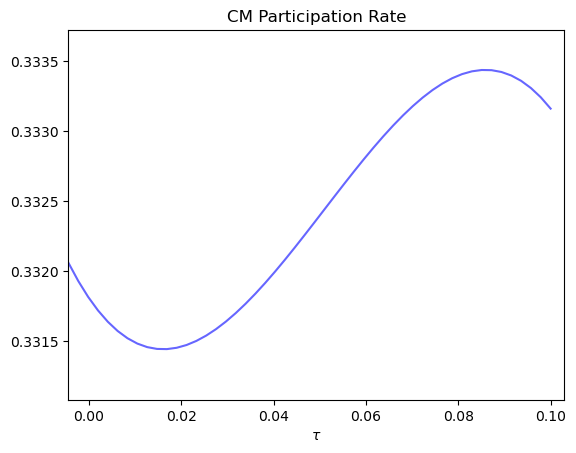

In [13]:
xmin, xmax = x.min(), x.max()
plt.figure()
plot2spline(x, CMPart, 
                alpha_raw=0.00, 
                SplineOrder=3, 
                N_xi=50, 
                SplineSmooth=1e-4,
                x_min=xmin,
                x_max=xmax*1.03,
            )
plt.xlabel(r'$\tau$')
plt.title("CM Participation Rate")
plt.show()

# Mean

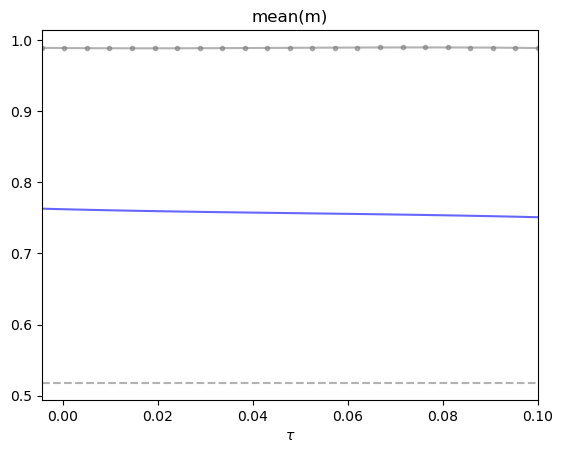

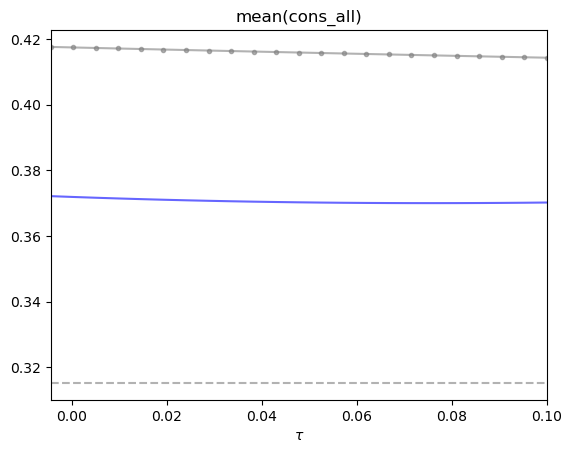

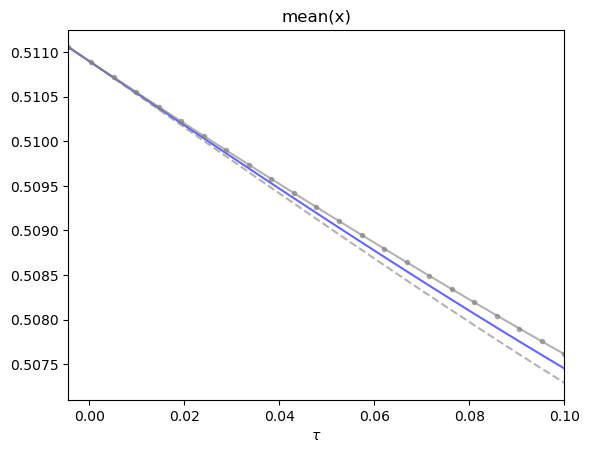

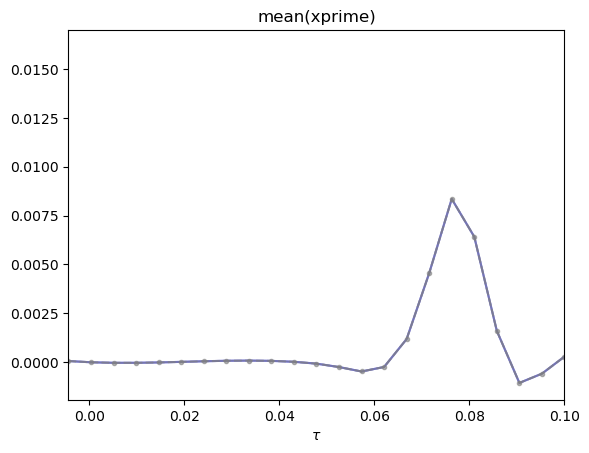

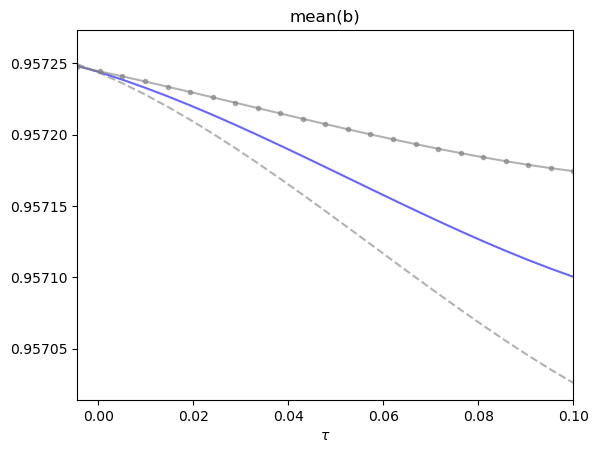

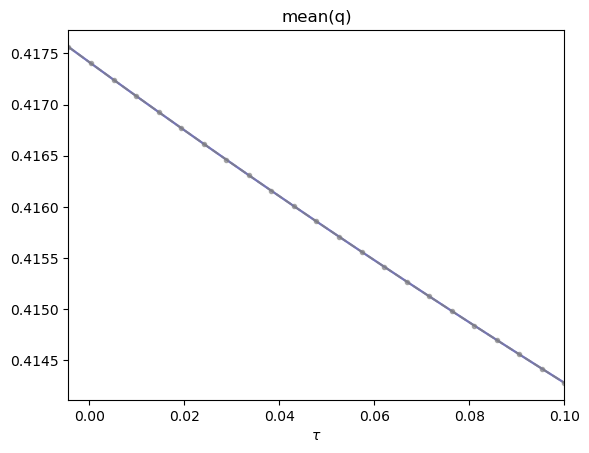

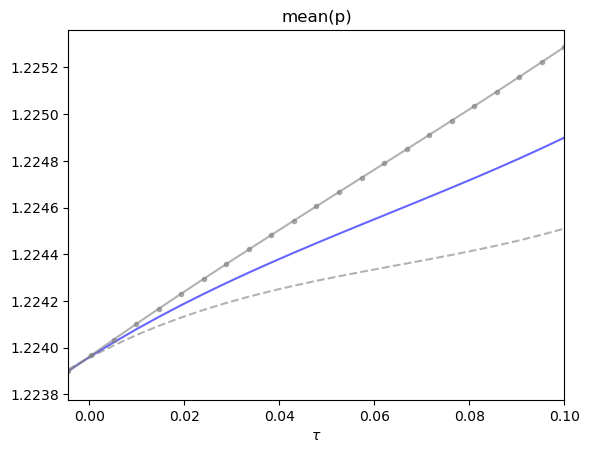

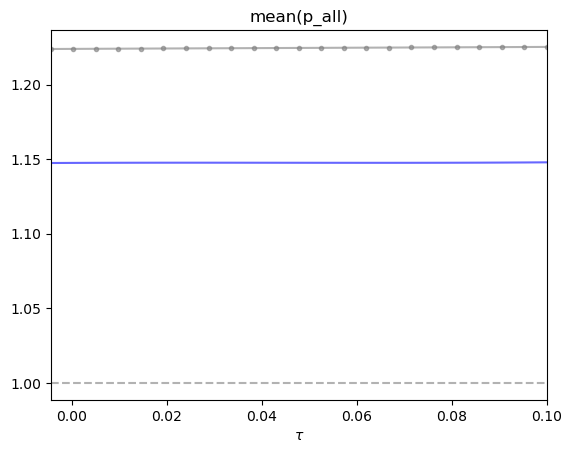

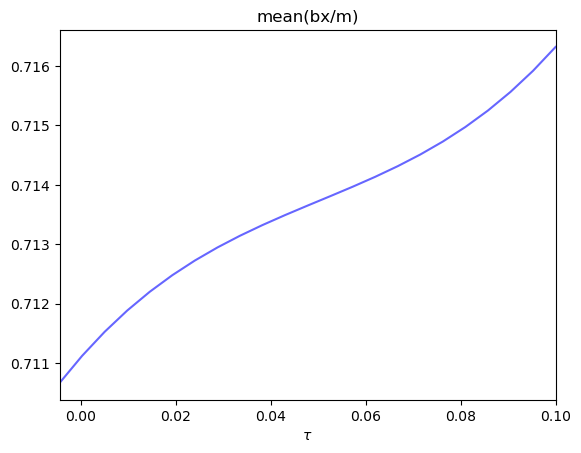

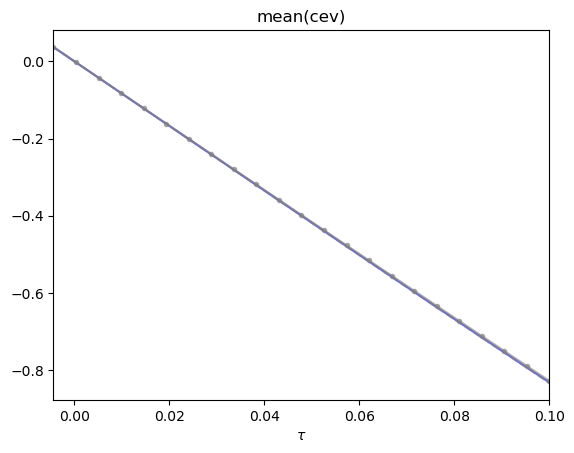

In [27]:
show_stats(x, y_stats, stat='mean', 
                        alpha_raw=0.00, 
                        ratio_scale=False,
                        N_xi=23, 
                        x_min=x.min(), 
                        x_max=0.10,
                        ShowNinetyTen=True,
                        SplineOrder=3,
          )

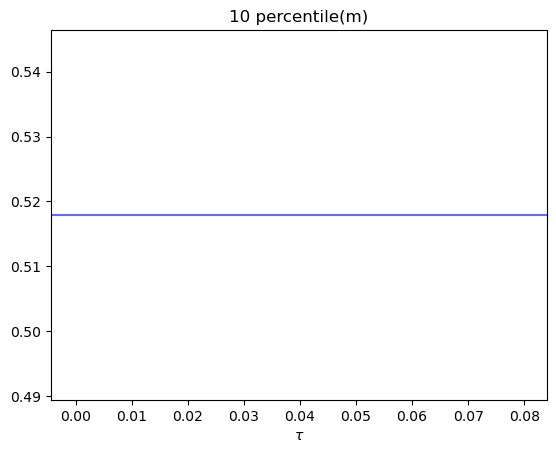

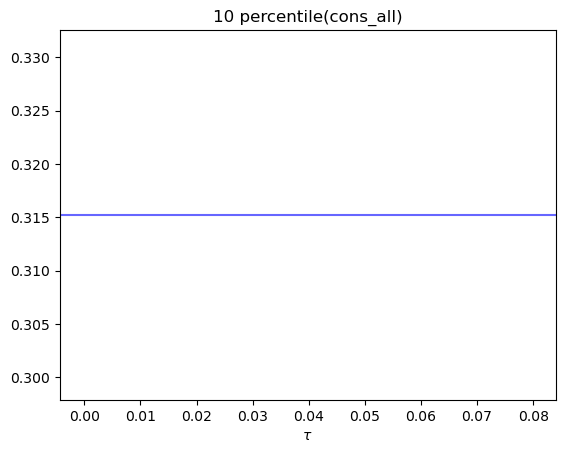

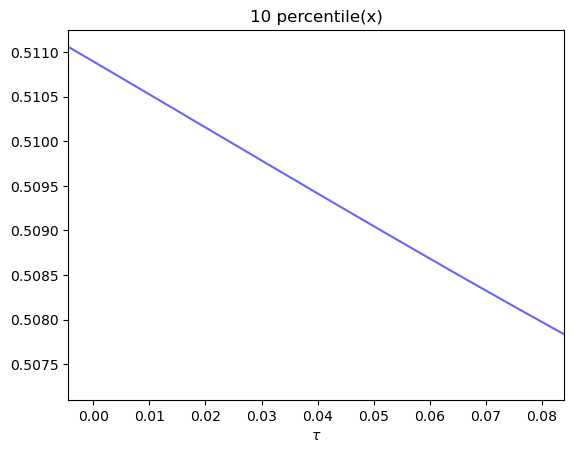

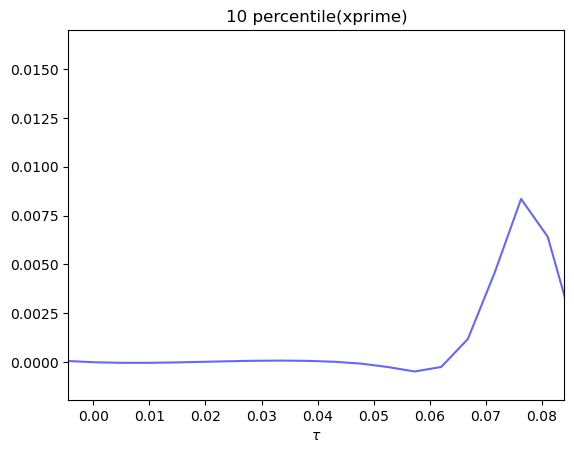

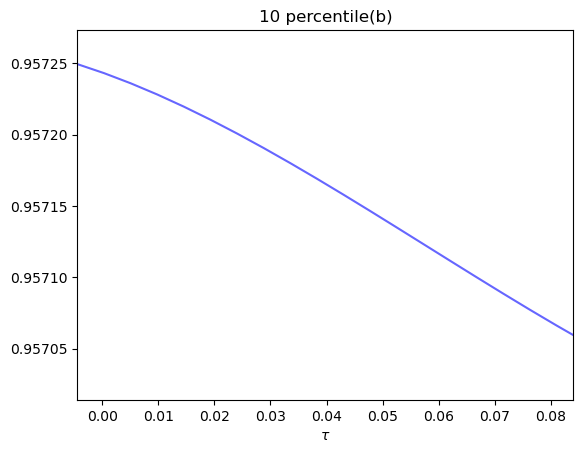

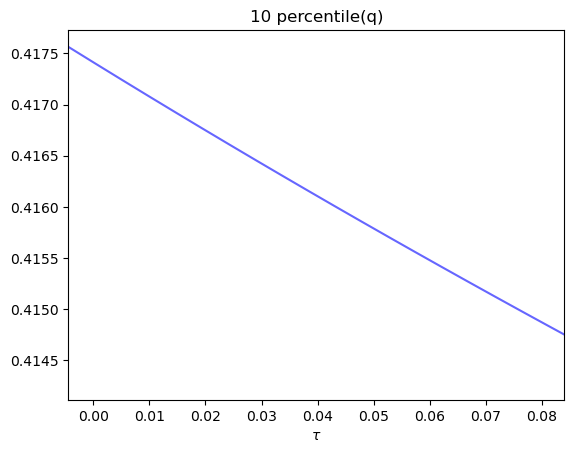

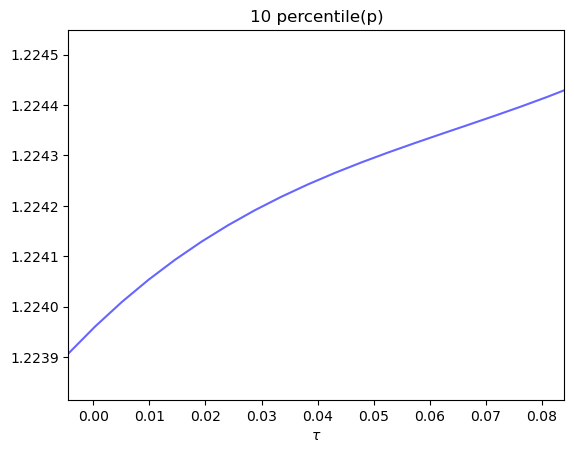

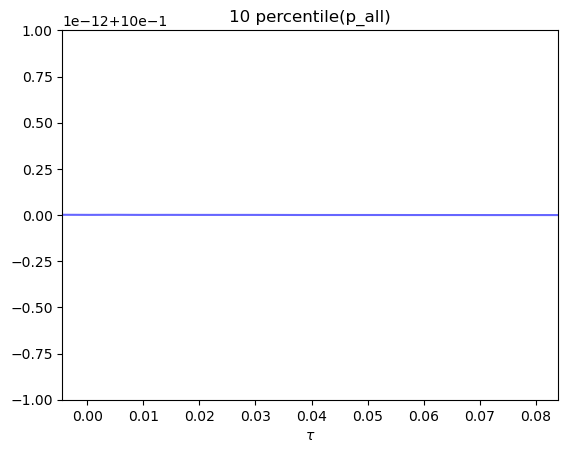

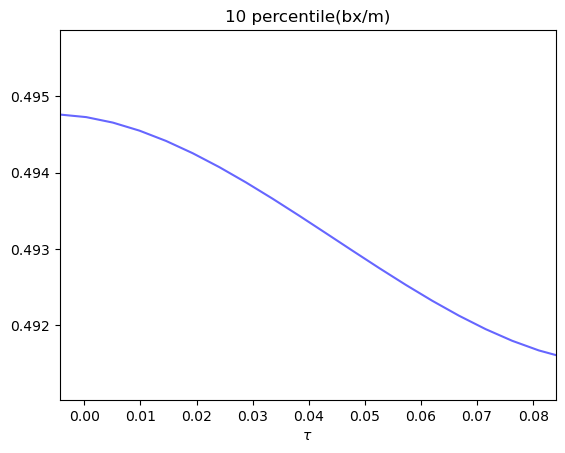

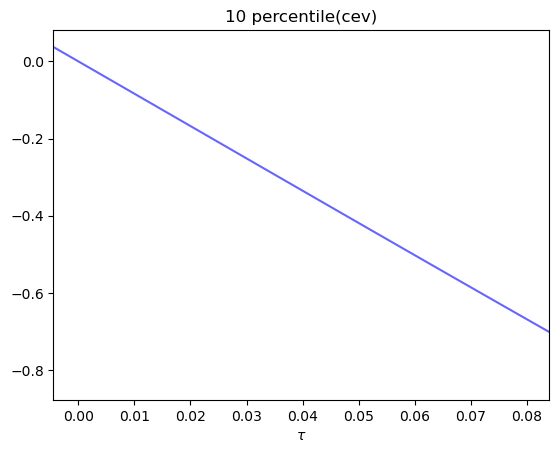

In [15]:
show_stats(x, y_stats, stat='10 percentile', alpha_raw=0.00, 
                        N_xi=23, 
                        x_min=x.min(), 
                        x_max=0.084,)

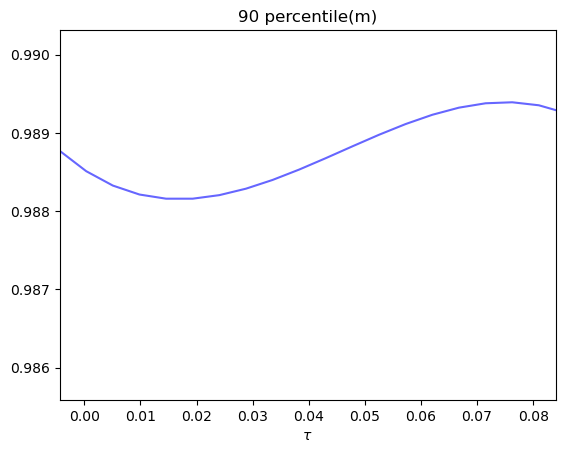

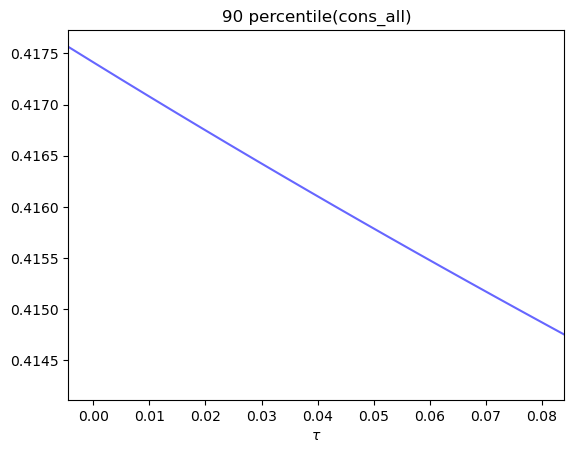

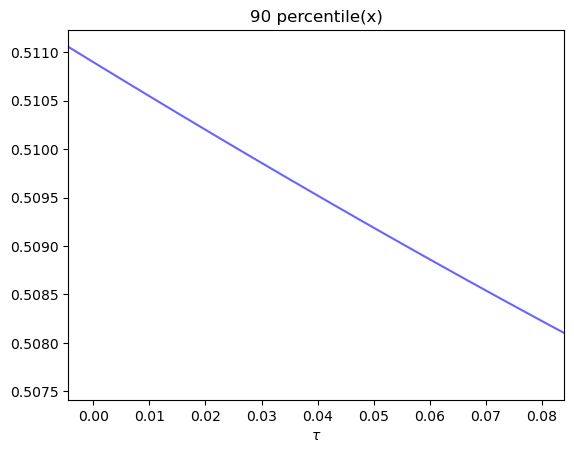

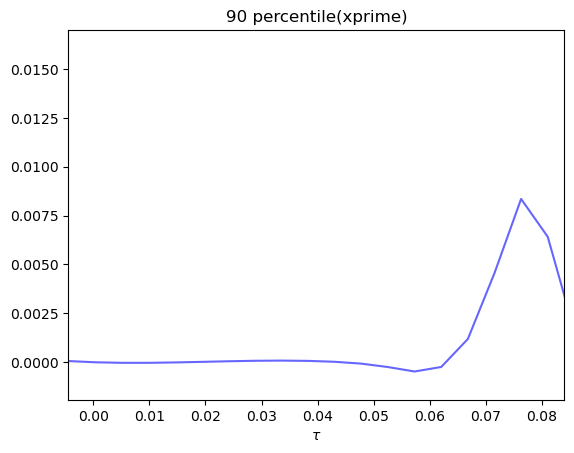

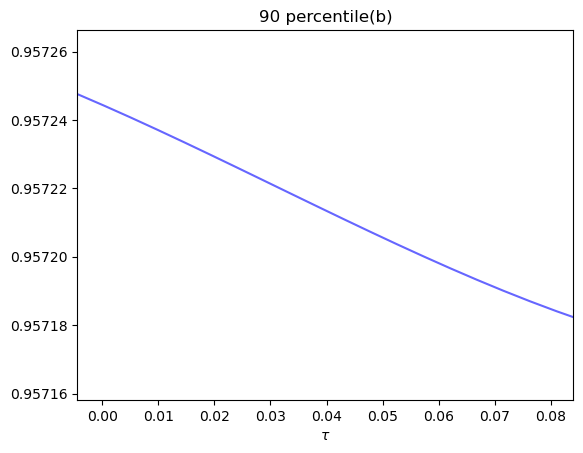

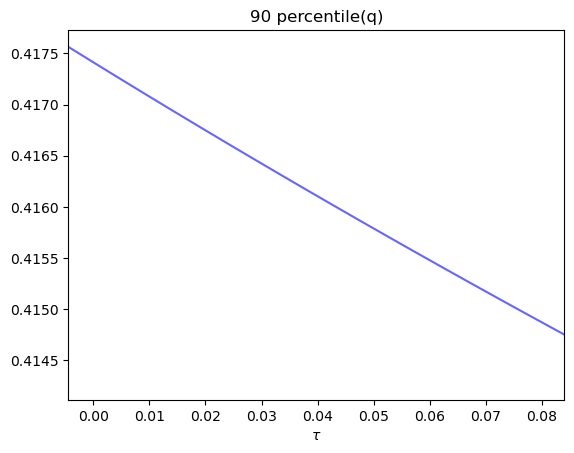

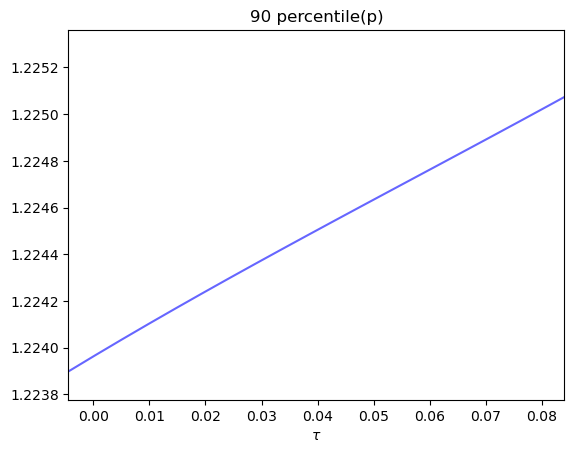

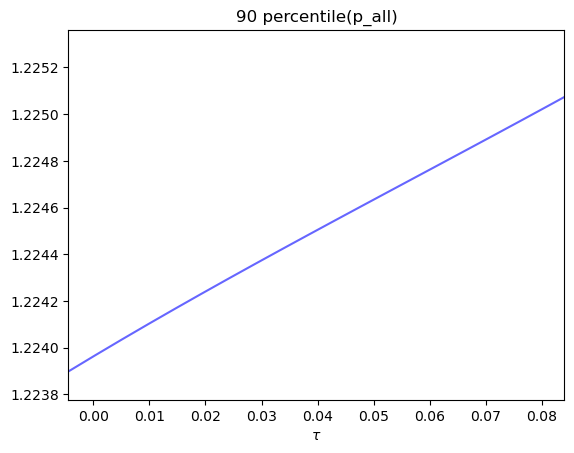

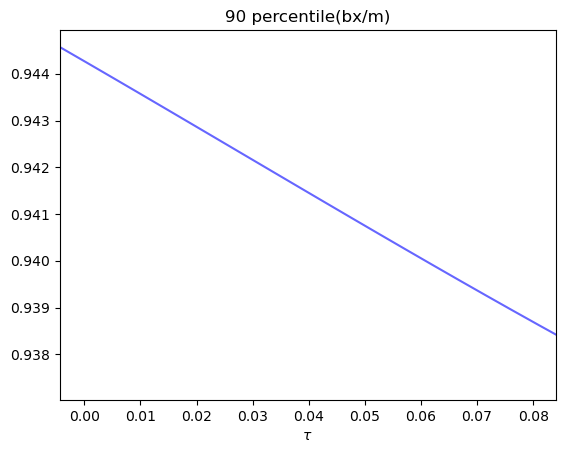

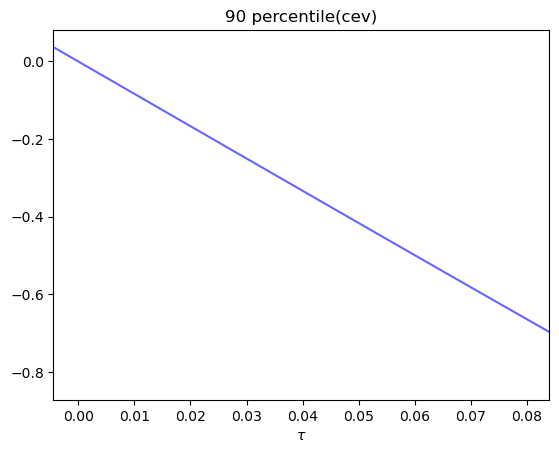

In [16]:
show_stats(x, y_stats, 
                        stat='90 percentile', 
                        alpha_raw=0.0, 
                        N_xi=23, 
                        x_min=x.min(), 
                        x_max=0.084,)

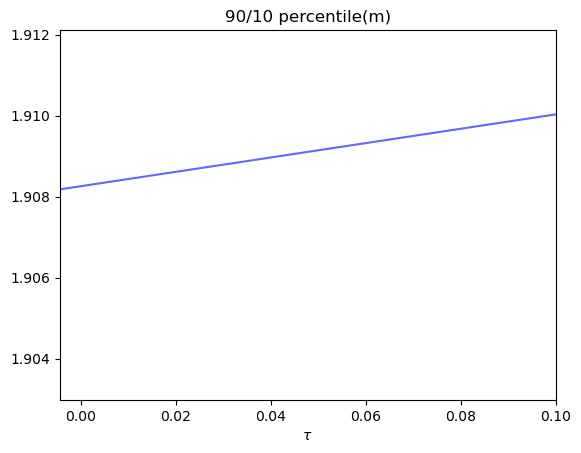

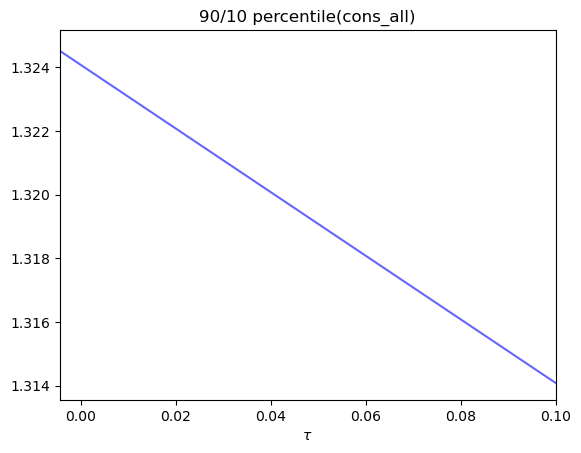

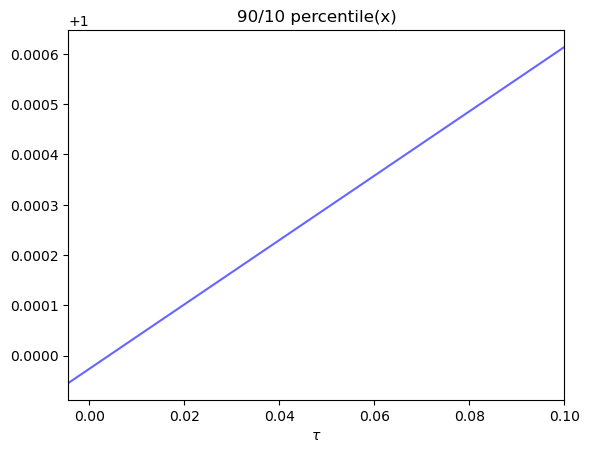

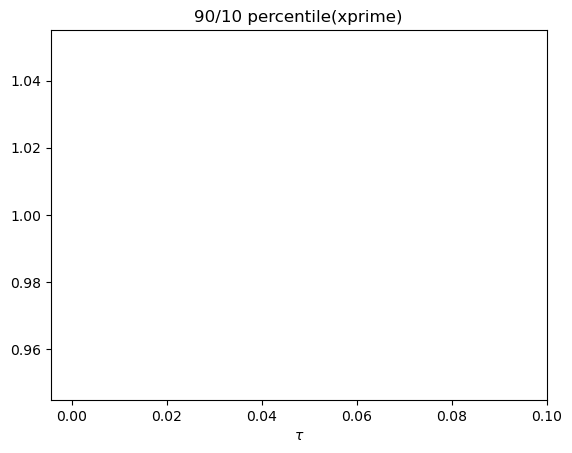

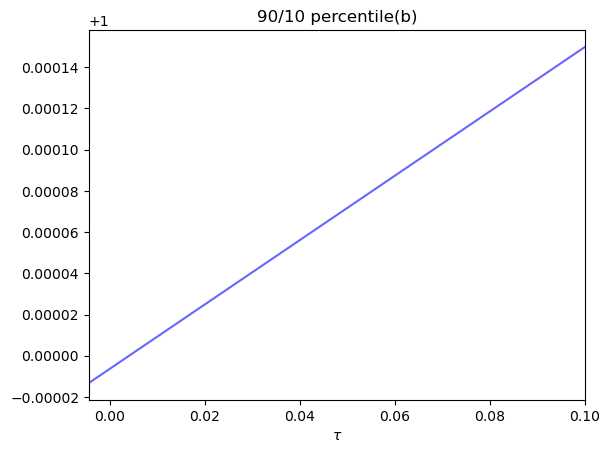

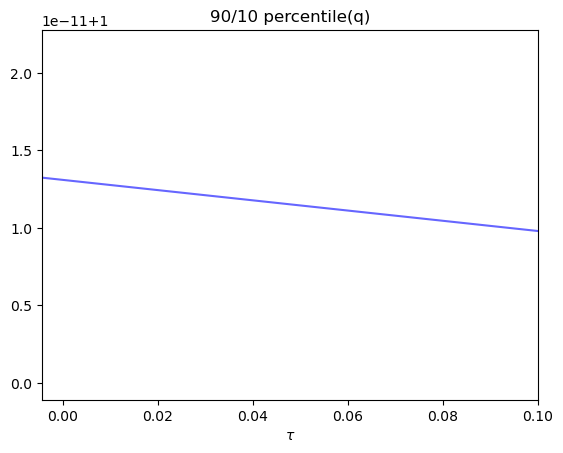

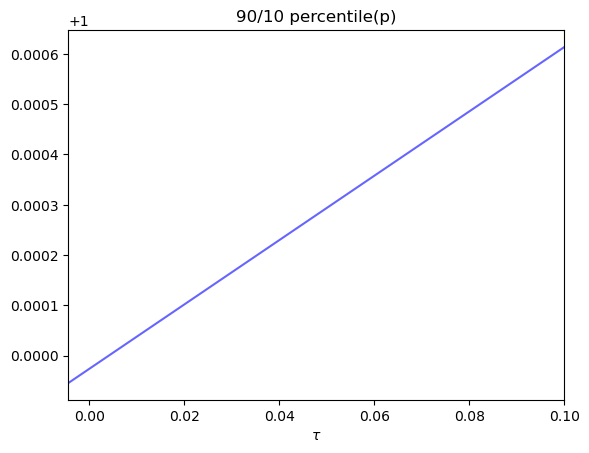

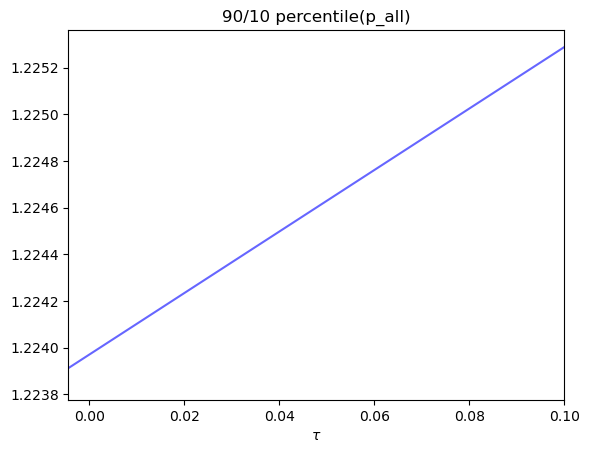

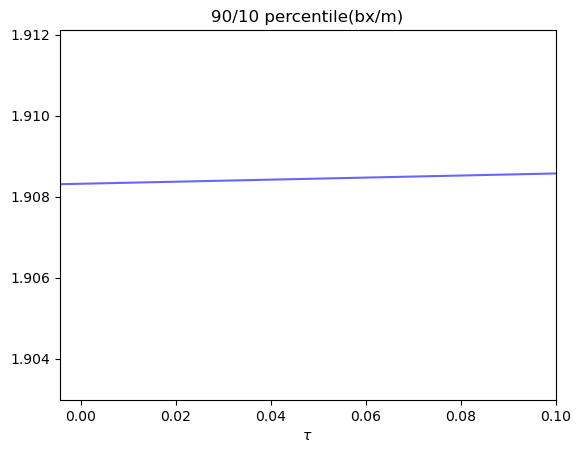

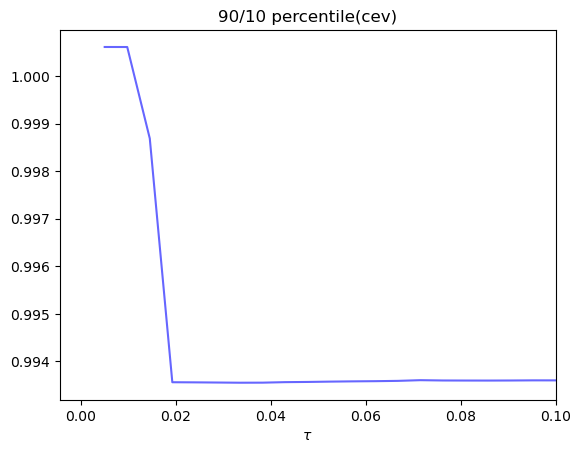

In [17]:
show_stats(x, y_stats, 
                    stat='90/10 percentile', 
                    alpha_raw=0.0, 
                    N_xi=23, 
                    x_min=x.min(), 
                    x_max=x.max(),
                    SplineOrder=1,
            )

# Standard deviation

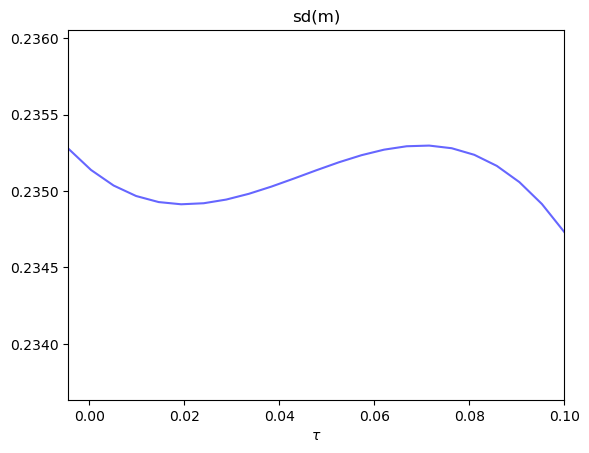

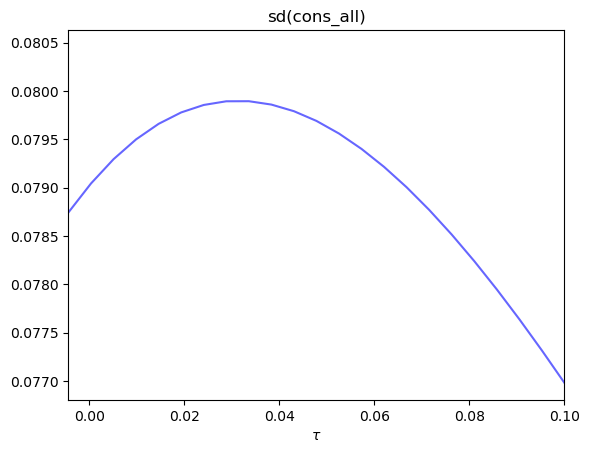

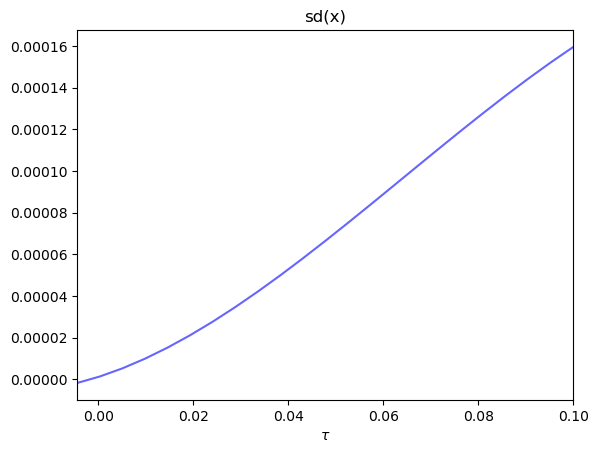

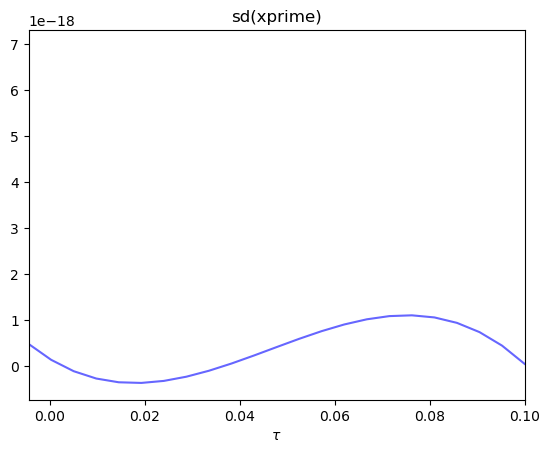

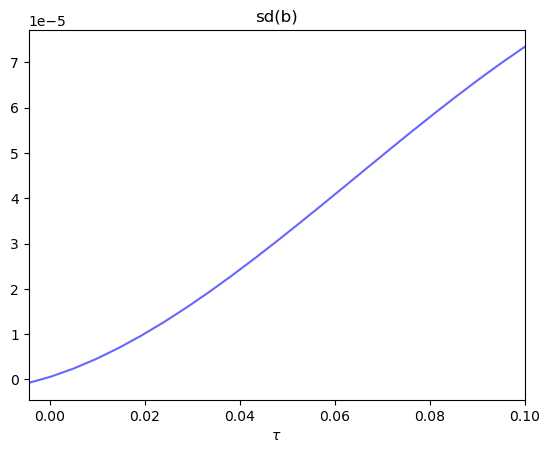

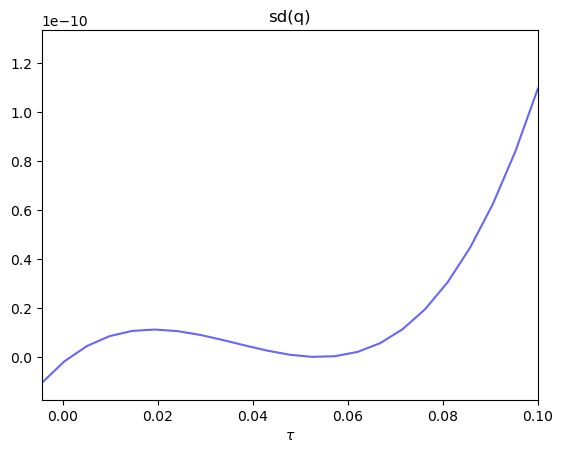

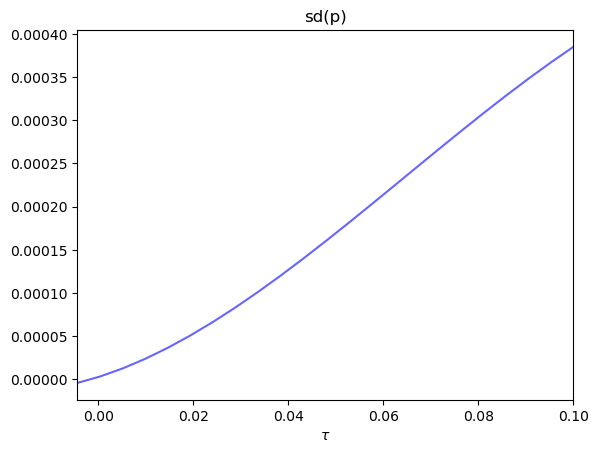

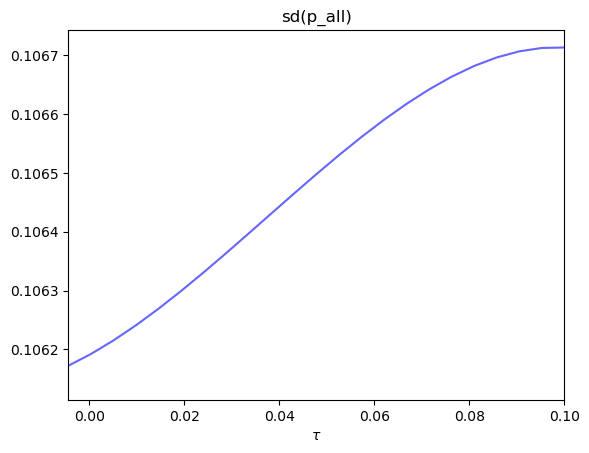

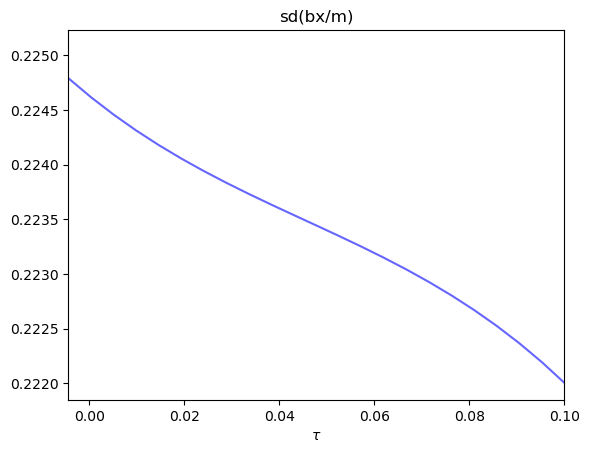

No data available!


In [25]:
show_stats(x, y_stats, 
                stat='sd', 
                alpha_raw=0.00, 
                N_xi=23, 
                x_min=x.min(), 
                x_max=0.10,)

# Welfare and Inequality

In [19]:
def gini_plot(x, gini, 
                    SplineOrder=4, 
                    SplineSmooth=1e-6, 
                    alpha_raw=0.001, 
                    alpha_fit=0.6, 
                    y_label=r'Gini $m$',
                    xlim=[x.min(), x.max()]):
    """Common function for gini coefficient vs τ (inflation)
    experiment results"""

    # Get a smoothed spline representation of the sample points
    gini_spl = UnivariateSpline(x, gini, k=SplineOrder)
    xi = np.linspace(x.min(), x.max(), 22)
    # Add exact τ=0 point
    xi = np.sort(np.append(xi, 0.0))

    plt.figure()
    gini_spl.set_smoothing_factor(SplineSmooth)
    # Raw data
    plt.plot(x, gini, 'o', color='blue', alpha=alpha_raw)
    # Spline fitted data
    yi = gini_spl(xi)
    plt.plot(xi, yi, '-', color='blue', alpha=alpha_fit)
    plt.plot(xi[xi==0.0], yi[xi==0.0], 'sg', label=r"$\tau=0\%$ p.a.")
    plt.plot(xi[xi==0.10], yi[xi==0.10], 'dr', label=r"$\tau=10\%$ p.a.")
    plt.xlabel(r'$\tau$')
    plt.title(y_label)
    plt.gca().set_xbound(xlim)
    plt.show()

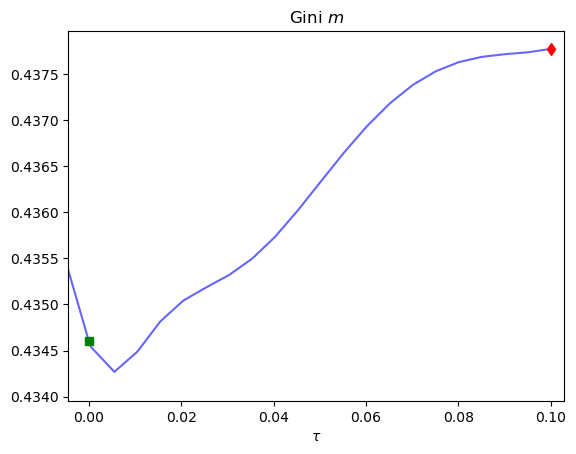

In [20]:
gini_plot(x, gini, xlim=[x.min(), x.max()*1.03])

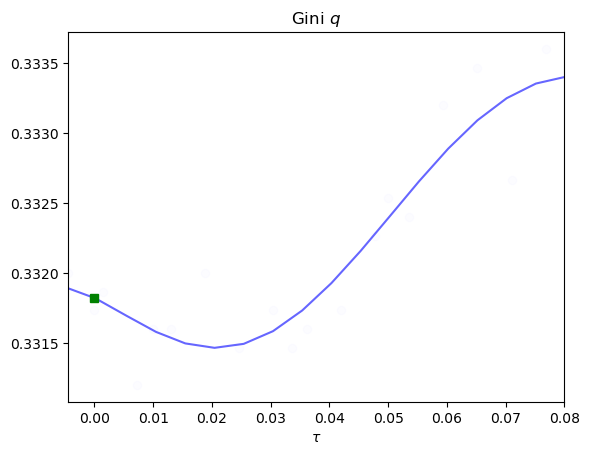

In [21]:
gini_plot(x, gini_q, alpha_raw=0.01,
             SplineOrder=5, 
             SplineSmooth=3, 
             xlim=[x.min(), 0.08], 
             y_label=r'Gini $q$')

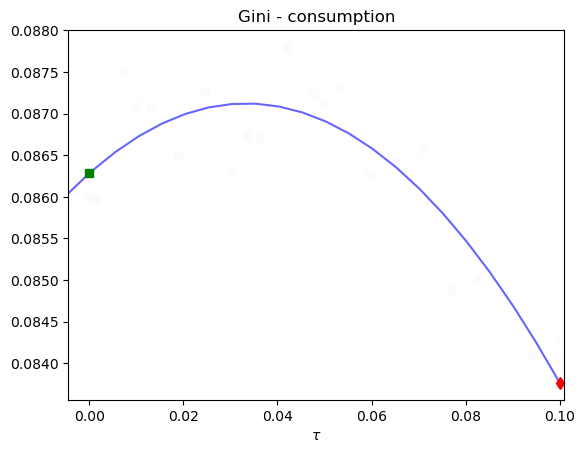

In [22]:
gini_plot(x, gini_cons, 
                alpha_raw=0.01, 
                SplineOrder=2, 
                SplineSmooth=0.9, 
                xlim=[x.min(), 0.101],
                y_label=r'Gini - consumption')

/tmp/ipykernel_26244/555992092.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cev0 = float(cev[x==0.0])
/tmp/ipykernel_26244/555992092.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cev1 = float(cev[x==0.10])


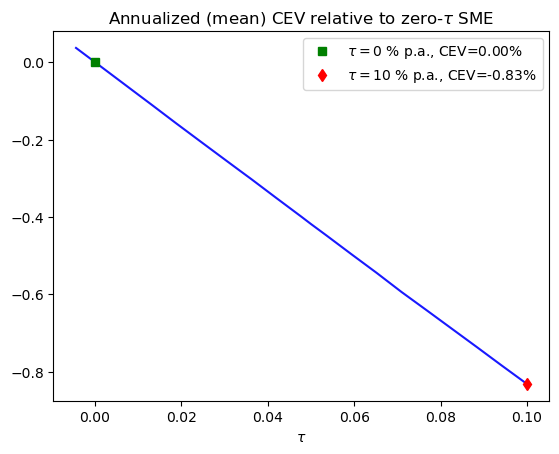

In [23]:
plt.figure()
plt.plot(x, cev, '-', color='blue', alpha=0.9)
cev0 = float(cev[x==0.0])
plt.plot(x[x==0.0], cev0, 'sg', 
        label=r"$\tau=0$ % p.a."+", CEV=" + "{:.2f}".format(cev0) + "%"
        )
cev1 = float(cev[x==0.10])
str_1 = r"$\tau=10$ % p.a."+", CEV=" + "{:.2f}".format(cev1) + "%"
plt.plot(x[x==0.10], cev1, 'dr', 
        label=str_1
        )
plt.xlabel(r'$\tau$')
plt.title(r'Annualized (mean) CEV relative to zero-$\tau$ SME')
plt.legend()
plt.show()